# Transfer Learning with Scaling-Up

> We have seen the power of transfer learning with `Feature Extraction and Fine-Tuning` of models.

> Now we would be using those models to train on the `Food101 dataset` with all the `101` food classes together.

**Food101 Dataset** -> https://www.kaggle.com/datasets/dansbecker/food-101

**Page With Code** -> https://paperswithcode.com/dataset/food-101

**Original Page** -> https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

> In the paper they used `Random Forest` and got an accuracy score of `50.76%`. 


> In this notebook, we will get a better score than the paper on only `10%` of the training data with all of the `101` classes in the dataset.  



In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.efficientnet import EfficientNetB0



## Importing helper functions

In [2]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-03 12:26:19--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14050 (14K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  13.72K  --.-KB/s    in 0s      

2022-08-03 12:26:19 (29.8 MB/s) - ‘helper_functions.py’ saved [14050/14050]



In [3]:
from helper_functions import make_confusion_matrix,compare_historys, unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir, model_check_point_callback, create_data_augmented_layer_for_model, create_feature_extraction_model

## Getting the data

> Using only `10%` of the data with all of the `101` food classes in the dataset.

> We are getting the datasets from the original Food101 dataset but it has been preprocessed using the `image_data_modification` notebook -> https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-08-03 12:26:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.181.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   181MB/s    in 9.9s    

2022-08-03 12:26:29 (156 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data('101_food_classes_10_percent.zip')

In [6]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images i

In [7]:
train_dir='101_food_classes_10_percent/train'
test_dir='101_food_classes_10_percent/test'

In [8]:
len(train_dir)

33

In [9]:
IMG_SIZE= (224,224)
BATCH_SIZE=32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode="categorical", image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE,shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Creating a model with transfer learning with 10% of the 101 food classes dataset

* Create ModelCheckpoint callback
* Create Data Augmentation layer for the model
* Build a *feature extraction model* with `EfficientNet_B0` architecture and a custom output layer

### ModelCheckpoint callback

In [10]:
file_path= '101_classes_10_percent_model_checkpoint'
model_check_point_callback=model_check_point_callback(file_path, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
model_check_point_callback

### Data Augmentation Layer

In [11]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

### Tensorflow Callback

In [12]:
tensorboard_dir_name="(transfer_learning)", 
tensorboard_experiment_name="(10_percent_data_augmented_feature_extraction)"

In [13]:
len(train_data_10_percent.class_names)

101

### Creating the feature-extraction model

In [14]:
INPUT_SHAPE=(224,224,3)
CLASS_COUNT= len(train_data_10_percent.class_names)
EPOCHS=10

# create_feature_extraction_model(data_augmented_layer=augmented_layer, model_checkpoint_callback=model_check_point_callback, input_shape=INPUT_SHAPE, base_model_name=EfficientNetB0, include_top=False, class_count=CLASS_COUNT,train_data=train_data_10_percent, test_data=test_data, epochs=EPOCHS, tensorboard_dir_name=tensorboard_dir_name,tensorboard_experiment_name= tensorboard_experiment_name)

In [15]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_0= keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

history_0_10_percent= model_0.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction"), model_check_point_callback])



16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented_feature_extraction/20220803-122652
Epoch 1/10
237/237 [==============================] - ETA: 0s - loss: 3.4528 - accuracy: 0.2570
Epoch 1: val_accuracy improved from -inf to 0.35169, saving model to 101_classes_10_percent_model_checkpoint
237/237 [==============================] - 99s 344ms/step - loss: 3.4528 - accuracy: 0.2570 - val_loss: 2.7632 - val_accuracy: 0.3517
Epoch 2/10
237/237 [==============================] - ETA: 0s - loss: 2.3406 - accuracy: 0.4594
Epoch 2: val_accuracy improved from 0.35169 to 0.43459, saving model to 101_classes_10_percent_model_checkpoint
237/237 [==============================] - 63s 264ms/step - loss: 2.3406 - accuracy: 0.4594 - val_loss: 2.2931 - val_accuracy: 0.4346
Epoch 3/10
237/237 [==============================] - ETA: 0s - loss: 1.9717 - accuracy: 0.5288
Epoch 3: val_accuracy improved from 0.43459 to

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2D (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [17]:
model_0.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 1.6520 - accuracy: 0.5616


[1.6519947052001953, 0.561623752117157]

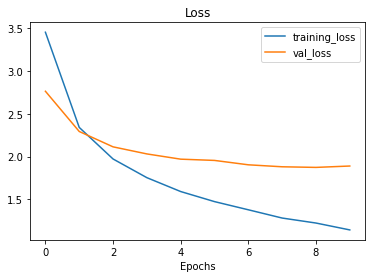

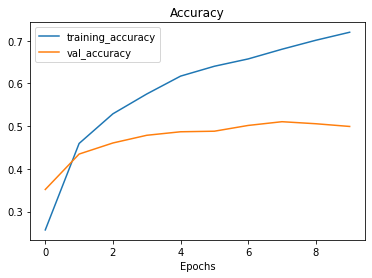

In [18]:
plot_loss_curves(history_0_10_percent)

> The graphs are suggesting that the `model_0` is `overfitting` on the training data. In other words, it is `not generalizing the patterns` it learns from the training data when coming across the `test/validation` data

In [19]:
result_model_0_feature_extraction= model_0.evaluate(test_data)
result_model_0_feature_extraction

790/790 [==============================] - 57s 72ms/step - loss: 1.6520 - accuracy: 0.5616


[1.6519947052001953, 0.561623752117157]

## Fix overfitting of the model

> We could try `GlobalMaxPooling2D` instead of `GlobalAveragePooling2D` to see if it improves the overfitting issue or not.

**Docs** -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D

> Try `GlobalMaxPooling2D` but the accuracy(46.78%) was much worse compared to `GlobalAveragePooling2D` which was 56.21% and the overfitting issue was still.

> The values from the model trained with `GlobalMaxPooling2D`:

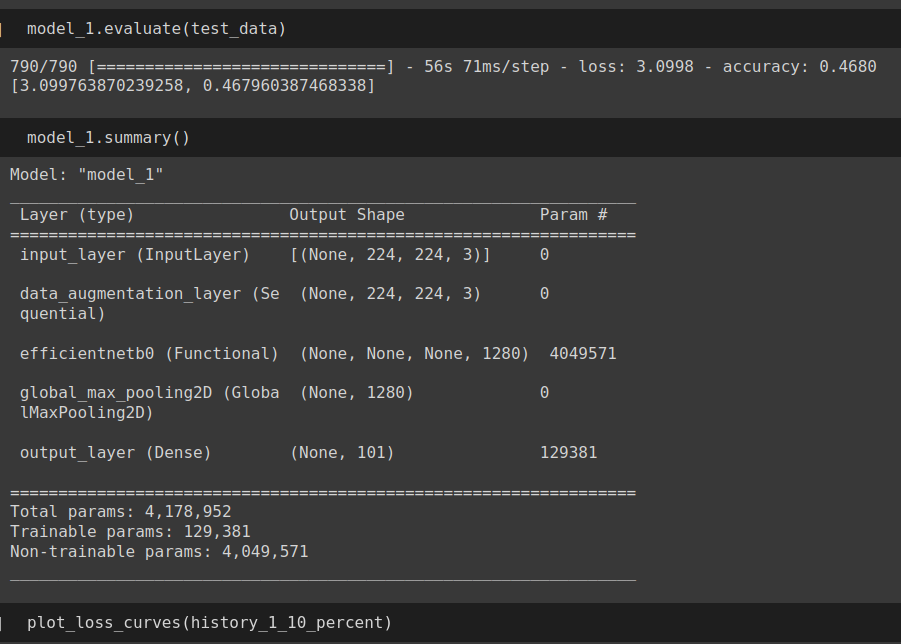


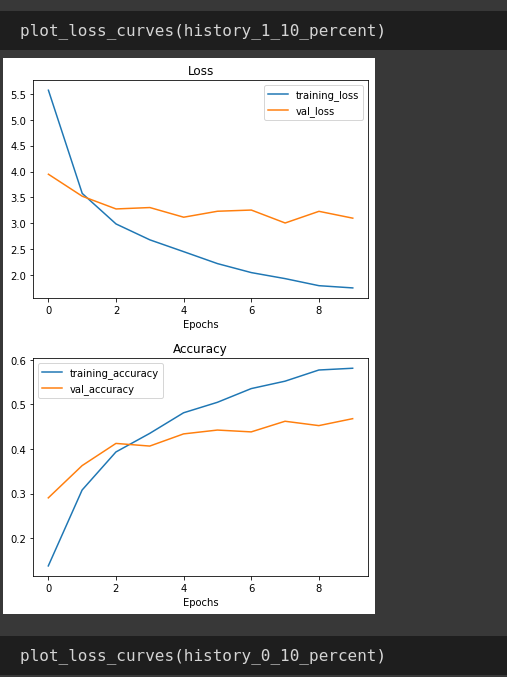

## Trying the Dropout layer to fix overfitting

**Docs** -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout


In [20]:
# input_shape=(224,224,3)

# base_model= EfficientNetB0(include_top=False)
# base_model.trainable= False

# inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

# x= augmented_layer(inputs)

# x= base_model(x, training=False)

# x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# # To minimize Overfitting of the model
# x = tf.keras.layers.Dropout(0.5)(x)

# outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

# model_1= keras.Model(inputs, outputs)

# model_1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

# history_1_10_percent= model_1.fit(train_data_10_percent, 
#                                   epochs=10, steps_per_epoch=len(train_data_10_percent), 
#                                   validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
#                                   callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction")])



In [21]:
# model_1.evaluate(test_data)

In [22]:
# model_1.summary()

In [23]:
# plot_loss_curves(history_1_10_percent)

In [24]:
# plot_loss_curves(history_0_10_percent)

In [25]:
# result_model_1_feature_extraction= model_1.evaluate(test_data)
# result_model_1_feature_extraction

In [26]:
# result_model_0_feature_extraction

## Conclusion

> The `Dropout` layer added to the feature extraction model has helped in reducing `overfitting` of the model. After seeing the graphs of both the models, it is clear `Dropout` layers helps in reducing `overfitting` of the model.

* Model With `Dropout` layer

> **Loss** -> 1.6728649139404297, **Accuracy** -> 0.5590494871139526

* Model without `Dropout` layer
 
> **Loss** -> 1.6465145349502563, **Accuracy** -> 0.5621781945228577

 



## Finding the ideal Learning rate

### Learning Rate Callback

In [27]:
lr_callback=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/2))

In [28]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_2= keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

history_2_10_percent= model_2.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction"), lr_callback])



Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented_feature_extraction/20220803-124045
Epoch 1/10
237/237 [==============================] - 47s 173ms/step - loss: 3.7748 - accuracy: 0.1711 - val_loss: 2.9546 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 2/10
237/237 [==============================] - 36s 150ms/step - loss: 2.6346 - accuracy: 0.3629 - val_loss: 2.2687 - val_accuracy: 0.4256 - lr: 0.0032
Epoch 3/10
237/237 [==============================] - 39s 163ms/step - loss: 2.9049 - accuracy: 0.3638 - val_loss: 2.7114 - val_accuracy: 0.3994 - lr: 0.0100
Epoch 4/10
237/237 [==============================] - 37s 154ms/step - loss: 7.3854 - accuracy: 0.2694 - val_loss: 8.2450 - val_accuracy: 0.2879 - lr: 0.0316
Epoch 5/10
237/237 [==============================] - 35s 144ms/step - loss: 25.0694 - accuracy: 0.2370 - val_loss: 21.6519 - val_accuracy: 0.3504 - lr: 0.1000
Epoch 6/10
237/237 [==============================] - 33s 138ms/step - loss: 76.6066 - accuracy:

Text(0.5, 1.0, 'Finding the ideal learning rate')

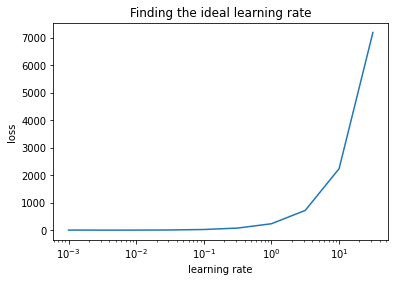

In [29]:
lrs=1e-3 *(10**(tf.range(10)/2))
plt.semilogx(lrs, history_2_10_percent.history["loss"])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.title("Finding the ideal learning rate")

> Let's try a learning_rate of `0.0001`

In [30]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_3= keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

history_3_10_percent= model_3.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction")])



Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented_feature_extraction/20220803-124757
Epoch 1/10
237/237 [==============================] - 41s 147ms/step - loss: 4.6781 - accuracy: 0.0219 - val_loss: 4.3196 - val_accuracy: 0.0553
Epoch 2/10
237/237 [==============================] - 31s 128ms/step - loss: 4.3538 - accuracy: 0.0582 - val_loss: 4.0789 - val_accuracy: 0.1316
Epoch 3/10
237/237 [==============================] - 33s 138ms/step - loss: 4.0764 - accuracy: 0.1137 - val_loss: 3.8643 - val_accuracy: 0.2090
Epoch 4/10
237/237 [==============================] - 31s 129ms/step - loss: 3.8578 - accuracy: 0.1609 - val_loss: 3.6824 - val_accuracy: 0.2569
Epoch 5/10
237/237 [==============================] - 33s 139ms/step - loss: 3.6523 - accuracy: 0.2081 - val_loss: 3.5257 - val_accuracy: 0.3008
Epoch 6/10
237/237 [==============================] - 33s 137ms/step - loss: 3.4982 - accuracy: 0.2413 - val_loss: 3.3863 - val_accuracy: 0.3271
Epoch 7/10
237/237

In [31]:
model_3.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 2.7418 - accuracy: 0.4397


[2.7418394088745117, 0.4396831691265106]

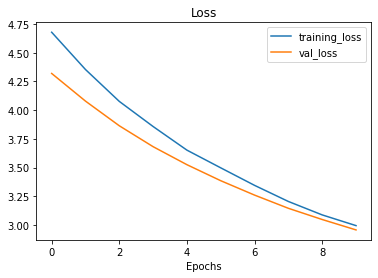

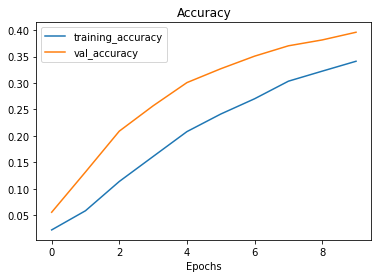

In [32]:
plot_loss_curves(history_3_10_percent)

> Let's try a learning_rate of `0.01`

In [33]:
# input_shape=(224,224,3)

# base_model= EfficientNetB0(include_top=False)
# base_model.trainable= False

# inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

# x= augmented_layer(inputs)

# x= base_model(x, training=False)

# x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# # To minimize Overfitting of the model
# x = tf.keras.layers.Dropout(0.5)(x)

# outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

# model_4= keras.Model(inputs, outputs)

# model_4.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# history_4_10_percent= model_4.fit(train_data_10_percent, 
#                                   epochs=10, steps_per_epoch=len(train_data_10_percent), 
#                                   validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
#                                   callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction")])



In [34]:
# model_4.evaluate(test_data)

In [35]:
# plot_loss_curves(history_4_10_percent)

> `0.01`  learning_rate is not the one, as the `validation_loss` is all over the place and it is increasing at the later epochs

Let's try learning rate of `0.0005` as this falls between `0.0001` and `0.001` learning rates

In [36]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_5= keras.Model(inputs, outputs)

model_5.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

history_5_10_percent= model_5.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction")])



Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented_feature_extraction/20220803-125444
Epoch 1/10
237/237 [==============================] - 37s 131ms/step - loss: 4.1444 - accuracy: 0.1056 - val_loss: 3.5019 - val_accuracy: 0.2820
Epoch 2/10
237/237 [==============================] - 30s 124ms/step - loss: 3.2378 - accuracy: 0.2824 - val_loss: 2.9509 - val_accuracy: 0.3837
Epoch 3/10
237/237 [==============================] - 29s 121ms/step - loss: 2.7959 - accuracy: 0.3575 - val_loss: 2.6526 - val_accuracy: 0.4264
Epoch 4/10
237/237 [==============================] - 31s 130ms/step - loss: 2.5322 - accuracy: 0.4180 - val_loss: 2.4570 - val_accuracy: 0.4452
Epoch 5/10
237/237 [==============================] - 32s 133ms/step - loss: 2.3587 - accuracy: 0.4469 - val_loss: 2.3020 - val_accuracy: 0.4642
Epoch 6/10
237/237 [==============================] - 32s 132ms/step - loss: 2.2280 - accuracy: 0.4698 - val_loss: 2.2386 - val_accuracy: 0.4695
Epoch 7/10
237/237

In [37]:
model_5.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.7935 - accuracy: 0.5471


[1.793478012084961, 0.5471287369728088]

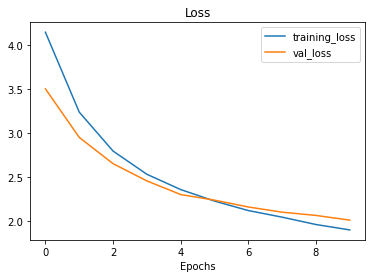

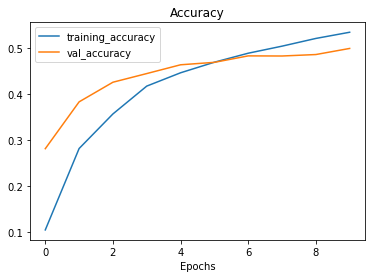

In [38]:
plot_loss_curves(history_5_10_percent)

## Conclusion

> From the above experiments, we can see that with the help of `Dropout` layer and changing/altering the learning rate of the optimizer has helped with lower the `overfitting` problem of the model.

> We can use either `0.0005` or `0.0001` as the learning rate value.


> `model_5` is the final feature_extraction model, we will `train it again` to `save the weights` of the model. This model will be used for `fine-tuning` later on

## Training `model_5` again to save the weights of the model

In [39]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_final= keras.Model(inputs, outputs)

model_final.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

history_final_10_percent= model_final.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction_final"), model_check_point_callback])



Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented_feature_extraction_final/20220803-130157
Epoch 1/10
237/237 [==============================] - ETA: 0s - loss: 4.1671 - accuracy: 0.1059
Epoch 1: val_accuracy did not improve from 0.51033
237/237 [==============================] - 37s 132ms/step - loss: 4.1671 - accuracy: 0.1059 - val_loss: 3.4817 - val_accuracy: 0.2934
Epoch 2/10
237/237 [==============================] - ETA: 0s - loss: 3.2549 - accuracy: 0.2801
Epoch 2: val_accuracy did not improve from 0.51033
237/237 [==============================] - 29s 120ms/step - loss: 3.2549 - accuracy: 0.2801 - val_loss: 2.9354 - val_accuracy: 0.3800
Epoch 3/10
237/237 [==============================] - ETA: 0s - loss: 2.8100 - accuracy: 0.3537
Epoch 3: val_accuracy did not improve from 0.51033
237/237 [==============================] - 31s 127ms/step - loss: 2.8100 - accuracy: 0.3537 - val_loss: 2.6278 - val_accuracy: 0.4280
Epoch 4/10
237/237 [===================

In [40]:
model_final.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 1.7992 - accuracy: 0.5444


[1.7992346286773682, 0.5443564653396606]

In [41]:
result_final_feature_exctration= model_final.evaluate(test_data)
result_final_feature_exctration

790/790 [==============================] - 57s 72ms/step - loss: 1.7992 - accuracy: 0.5444


[1.7992346286773682, 0.5443564653396606]

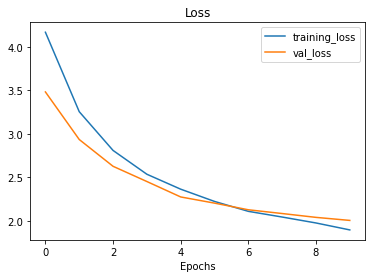

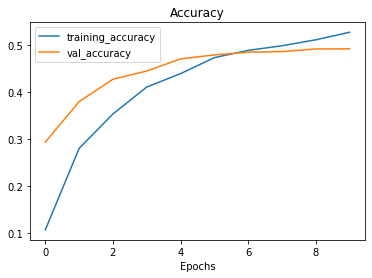

In [42]:
plot_loss_curves(history_final_10_percent)

## Unfreezing the last `20` layers for Fine-tuning `model_final`

* Learning Rate is `0.0005`

In [43]:
base_model.trainable= True

for layer in base_model.layers[:-20]:
  layer.trainable= False


model_final.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005))

In [44]:
for layer in model_final.layers[2].layers:
  if layer.trainable == True:
    print(layer, layer.name, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f25f1caa550> block6d_project_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f25f1c9a310> block6d_project_bn True
<keras.layers.core.dropout.Dropout object at 0x7f25f1cb63d0> block6d_drop True
<keras.layers.merge.Add object at 0x7f25f1c46850> block6d_add True
<keras.layers.convolutional.Conv2D object at 0x7f25f1c46b90> block7a_expand_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f25f1caaed0> block7a_expand_bn True
<keras.layers.core.activation.Activation object at 0x7f25f1cbab90> block7a_expand_activation True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f25f1c48910> block7a_dwconv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f25f1c50d90> block7a_bn True
<keras.layers.core.activation.Activation object at 0x7f25f1c50650> block7a_activation True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2

In [45]:
len(model_final.trainable_variables)

21

## Fine-Tuning `model_final` with `20` unfrozen layers

In [46]:
inital_epochs=10
fine_tune_epochs= inital_epochs + 10

history_10_percent_20_unfrozen=model_final.fit(train_data_10_percent, epochs=fine_tune_epochs, initial_epoch= history_final_10_percent.epoch[-1], steps_per_epoch=len(train_data_10_percent), validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_fine_tune_last_20_layers")] )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_20_layers/20220803-130950
Epoch 10/20
237/237 [==============================] - 41s 140ms/step - loss: 1.7493 - accuracy: 0.5438 - val_loss: 1.9699 - val_accuracy: 0.4841
Epoch 11/20
237/237 [==============================] - 30s 123ms/step - loss: 1.6317 - accuracy: 0.5729 - val_loss: 1.9146 - val_accuracy: 0.5026
Epoch 12/20
237/237 [==============================] - 32s 132ms/step - loss: 1.5733 - accuracy: 0.5847 - val_loss: 1.8929 - val_accuracy: 0.5114
Epoch 13/20
237/237 [==============================] - 32s 132ms/step - loss: 1.5166 - accuracy: 0.5983 - val_loss: 1.8729 - val_accuracy: 0.5162
Epoch 14/20
237/237 [==============================] - 33s 136ms/step - loss: 1.4842 - accuracy: 0.6034 - val_loss: 1.8032 - val_accuracy: 0.5318
Epoch 15/20
237/237 [==============================] - 30s 124ms/step - loss: 1.4522 - accuracy: 0.6136 - val_loss: 1.8114 - val_accuracy: 0.5283
Epoch 16/20
237/237 [

In [47]:
model_final.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 1.5049 - accuracy: 0.5958


[1.5048738718032837, 0.5958415865898132]

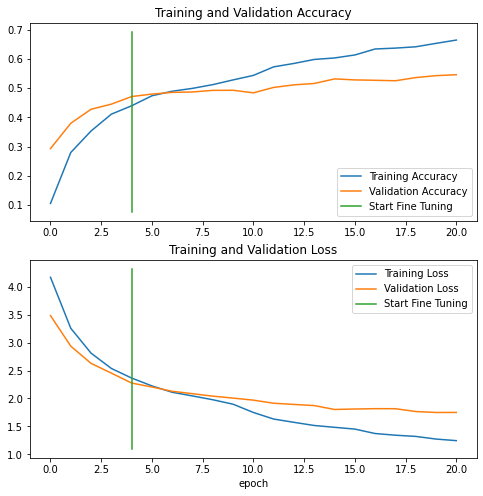

In [48]:
compare_historys(history_final_10_percent, history_10_percent_20_unfrozen)

> Model is `overfitting`, need to fit it.

In [49]:
model_final.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2D (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 101)               1293

In [50]:
result_1_fine_tuning=model_final.evaluate(test_data)
result_1_fine_tuning

790/790 [==============================] - 57s 73ms/step - loss: 1.5049 - accuracy: 0.5958


[1.5048738718032837, 0.5958415865898132]

In [51]:
result_final_feature_exctration

[1.7992346286773682, 0.5443564653396606]

## Saving and Loading Model

In [52]:
model_final.save('/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_final_saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_final_saved_model/assets


In [53]:
loaded_model= tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_final_saved_model')

## Evaluate Loaded model

In [54]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 60s 74ms/step - loss: 1.5049 - accuracy: 0.5958


[1.5048738718032837, 0.5958415865898132]

In [55]:
result_1_fine_tuning

[1.5048738718032837, 0.5958415865898132]

## Evaluating the performance of the `model_0` across different classes

> Making some predictions, vizualizing the predictions

> In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class

## Downloading a pre-trained model

Link -> https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [56]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-08-03 13:20:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  67.0MB/s    in 0.7s    

2022-08-03 13:20:51 (67.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [57]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [58]:
model_1 = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [59]:
result_loaded_model_1= model_1.evaluate(test_data)
result_loaded_model_1

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [60]:
result_1_fine_tuning

[1.5048738718032837, 0.5958415865898132]

## Making predictions with the trained model

In [61]:
preds_probs= model_final.predict(test_data, verbose=1)

790/790 [==============================] - 62s 76ms/step


In [ ]:
preds_probs_1= model_1.predict(test_data, verbose=1)

In [ ]:
len(preds_probs)

In [64]:
preds_probs.shape

(25250, 101)

In [ ]:
preds_probs[1]

> The model ouputs a `prediction probability` array(with `N` number of variables, where `N` is the number of classes) for each sample passed on the predict method.

In [66]:
preds_probs[1].shape

(101,)

In [67]:
len(preds_probs[1])

101

In [68]:
sum(preds_probs[1])

1.0000000951584411

In [69]:
np.argmin(preds_probs[1])

88

In [70]:
preds_probs[1].min()

3.6332423e-08

In [71]:
np.argmax(preds_probs[1])

0

In [72]:
preds_probs[1].max()

0.88567793

In [73]:
test_data.class_names[np.argmax(preds_probs[1])]

'apple_pie'

In [74]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 1: {len(preds_probs[1])}")
print(f"What prediction probability sample 1 looks like:\n {preds_probs[1]}")
print(f"The class with the highest predicted probability by the model for sample 1: {preds_probs[1].argmax()}")

Number of prediction probabilities for sample 1: 101
What prediction probability sample 1 looks like:
 [8.8567793e-01 1.7994269e-07 3.5485204e-03 9.5797986e-06 6.8520399e-07
 1.5304576e-07 1.1710357e-05 2.3817458e-06 9.7545235e-05 6.6604553e-05
 3.9051147e-06 2.1945532e-05 9.1399612e-05 8.3655514e-06 1.3329287e-03
 1.0185950e-05 3.8863826e-04 1.8098851e-04 8.1997539e-05 3.3344375e-03
 7.0592790e-07 4.7944125e-04 6.8532099e-05 6.8544477e-06 1.7283448e-03
 9.5577243e-06 4.3733024e-05 6.8234940e-06 1.2144153e-05 9.1385713e-04
 1.2373906e-06 8.9460600e-06 2.8194403e-03 1.9573508e-07 1.1953435e-07
 9.6991207e-06 4.7780352e-04 4.0804462e-05 1.5241589e-04 4.6373766e-06
 1.6692193e-05 5.4469955e-04 1.3250117e-06 2.8099802e-07 2.2435327e-06
 3.8980730e-07 1.7101602e-03 3.8580387e-05 4.0621623e-07 3.1583430e-05
 6.9040099e-05 3.8715852e-06 3.6221134e-04 7.2666198e-06 2.3468863e-07
 1.9367371e-06 6.8612666e-05 8.4062375e-02 9.1785967e-04 3.1150033e-04
 3.0379786e-06 2.6276109e-07 2.2313127e-04 3.

In [75]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [76]:
test_data.class_names[0]

'apple_pie'

## Get the pred class of each label

In [77]:
pred_classes= preds_probs.argmax(axis=1)


pred_classes[:5]

array([0, 0, 0, 8, 8])

In [78]:
len(pred_classes)

25250

> As we have got all the predictions array of all of the model's predictions, we need to evaluate them. In order to do so, we need to compare them to the original test dataset labels.

In [79]:
y_labels= []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)


## Evaluating on model's predictions

In [ ]:
result_loaded_model_1

In [ ]:
result_1_fine_tuning

### Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score

sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

In [ ]:
len(y_labels), len(pred_classes)

In [ ]:
train_data_10_percent.class_names, len(train_data_10_percent.class_names)

In [ ]:
class_names= train_data_10_percent.class_names
len(class_names)


### Confusion Matrix

In [ ]:
make_confusion_matrix(y_labels, pred_classes, class_names, figsize=(100,100), text_size=20)

### Changing some code of confusion matrix to look better

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

### Classification Report 

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true= y_labels, y_pred= pred_classes))

In [ ]:
class_names[33]

### Dictionary of the classification report

In [ ]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

In [ ]:
class_names

In [ ]:
class_names[69]

### Plotting all the f1-scores of the classes

In [95]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

{'apple_pie': 0.21182266009852216,
 'baby_back_ribs': 0.6035313001605136,
 'baklava': 0.6111111111111112,
 'beef_carpaccio': 0.6550868486352357,
 'beef_tartare': 0.4861111111111111,
 'beet_salad': 0.41685144124168516,
 'beignets': 0.7390476190476192,
 'bibimbap': 0.7743271221532091,
 'bread_pudding': 0.36026490066225164,
 'breakfast_burrito': 0.5007496251874063,
 'bruschetta': 0.47002398081534774,
 'caesar_salad': 0.6426966292134831,
 'cannoli': 0.6420824295010846,
 'caprese_salad': 0.5330578512396694,
 'carrot_cake': 0.5203883495145631,
 'ceviche': 0.32217573221757323,
 'cheese_plate': 0.5913043478260871,
 'cheesecake': 0.4163568773234201,
 'chicken_curry': 0.5059760956175299,
 'chicken_quesadilla': 0.587378640776699,
 'chicken_wings': 0.6813186813186813,
 'chocolate_cake': 0.5475285171102661,
 'chocolate_mousse': 0.35793357933579334,
 'churros': 0.72936660268714,
 'clam_chowder': 0.678038379530917,
 'club_sandwich': 0.6832579185520362,
 'crab_cakes': 0.37168141592920356,
 'creme_brul

### Turning the dictionary into a dataframe

In [ ]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores

In [ ]:
f1_scores.class_names

In [ ]:
f1_scores.class_names[33]

In [ ]:
f1_scores["f1-score"][33]

### Visualizing the F1-score

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
pred_classes

## Visualizing predictions on test images

> Visualizing and making predictions on the `test dataset`, by the model.

> To visualize the model's predictions on `cusotm images`, we need to create a function which will preprocess the `custom loaded data`.

* Read in the target image filepath using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images on which the model was trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1(If necessary)

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

## Visualize random Images from test dataset

> Visualize images, their target labels, and the model's predictions

* Load some random images from test dataset
* Make predictions on the loaded images
* Plot the original image along with the model's predictions, prediction probability and truth label

In [ ]:
import os
import random

In [ ]:
random.choice(class_names)

In [ ]:
test_dir

In [ ]:
random.choice(os.listdir(test_dir + "/" + class_name))

In [ ]:
filepath = test_dir + "/" + class_name + "/" + filename
filepath

In [ ]:
img=load_and_prep_image(filepath, scale=False)
img

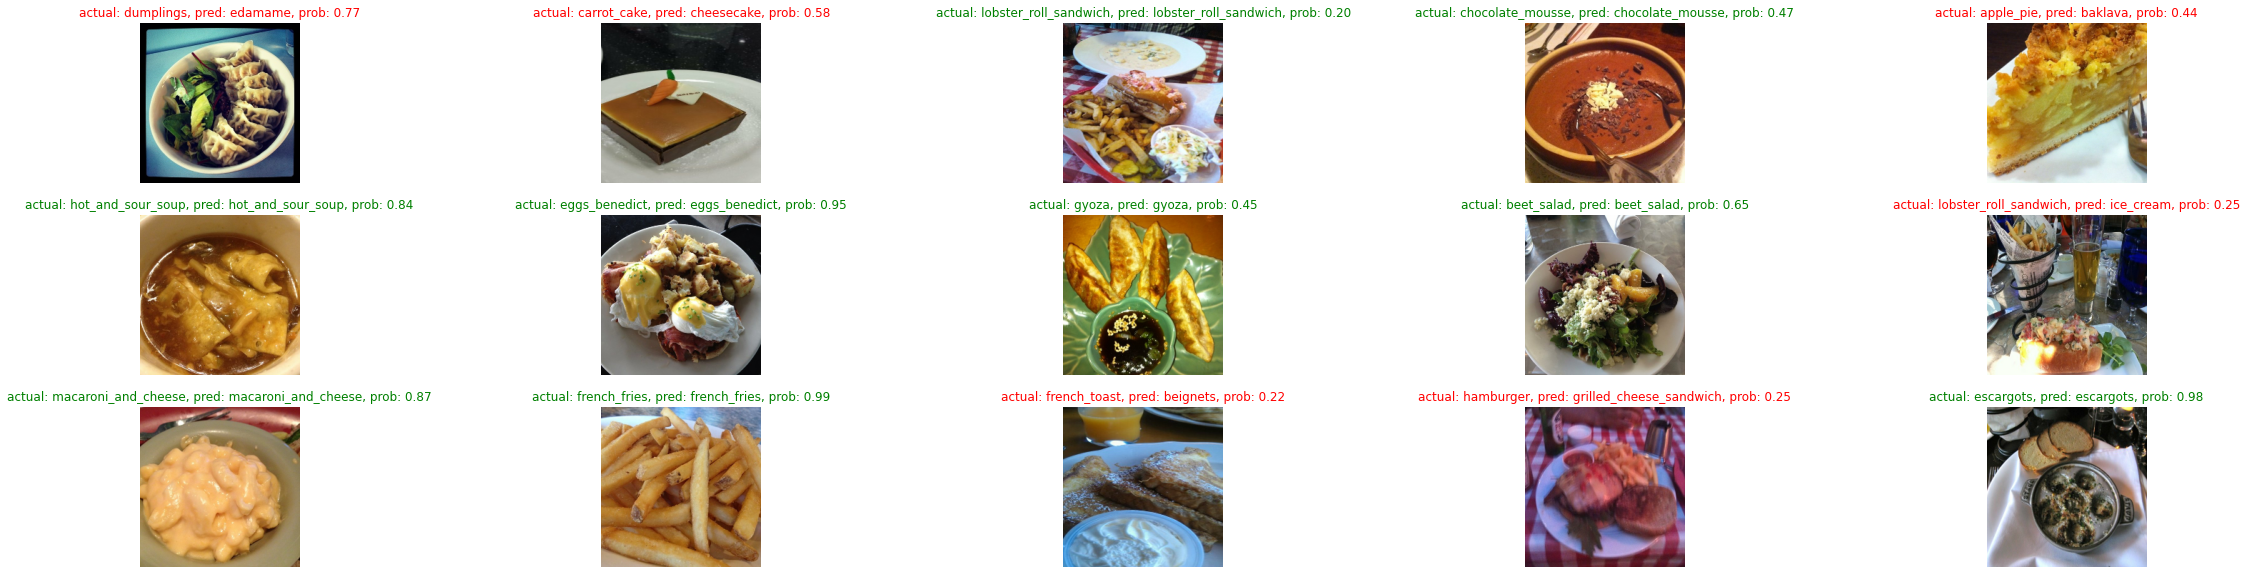

In [117]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(40,10))
for i in range(15):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  img_expanded=tf.expand_dims(img, axis=0)
  pred_prob = model_final.predict(img_expanded) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 5, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions


> It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

> After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

> These most wrong predictions can help to give further insight into your model's performance.

> So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

* We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
> Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.



In [110]:
filepaths= []

for path in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle= False):

  filepaths.append(path.numpy())

In [111]:
filepaths[:5]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg']

## Create a DataFrame for different parameters of out test images


* Their ground truth labels (y_labels).
* The class the model predicted (pred_classes).
* The maximum prediction probabilitity value (preds_probs.max(axis=1)).
* The ground truth class names.
* The predicted class names.


In [112]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0       0   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       8   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.438769        apple_pie        apple_pie  
1   0.885678        apple_pie        apple_pie  
2   0.373440        apple_pie        apple_pie  
3   0.180667        apple_pie    bread_pudding  
4   0.307172        apple_pie    bread_pudding

## Using the dataframe we are finding which predictions are wrong

In [113]:
pred_df["pred_correct"]= pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0       0   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       8   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.438769        apple_pie        apple_pie          True  
1   0.885678        apple_pie        apple_pie          True  
2   0.373440        apple_pie        apple_pie          True  
3   0.180667        apple_pie    bread_pudding         False  
4   0.307172        apple_pie    bread_pudding         False

## Sort the dataframe to have the most wrong predictions at the top

In [114]:
wrong_pred_df= pred_df[pred_df['pred_correct'] == False].sort_values("pred_conf", ascending=False)
wrong_pred_df

img_path  y_true  y_pred  \
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
8794   b'/content/101_food_classes_10_percent/test/es...      35      41   
...                                                  ...     ...     ...   
22415  b'/content/101_food_classes_10_percent/test/sh...      89      18   
15564  b'/content/101_food_classes_10_percent/test/ma...      62       8   
10770  b'/content/101_food_classes_10_percent/test/fr...      43      58   
971    b'/content/101_food_classes_10_percent/test/be...       3      82   
6277   b'/content/101_food_classes_10_percent/test/cl...      25      57   

       pred_conf       y_true_classname   y_pred_classname  pred_correct  
23631   0.998809   strawberry_shortcake    red_velvet_cake         False  
23797   0.998508                  sushi            sashimi         False  
15359   0.994205  lobster_roll_sandwich          hamburger         False  
10847   0.992964         fried_calamari        onion_rings         False  
8794    0.992038              escargots  french_onion_soup         False  
...          ...                    ...                ...           ...  
22415   0.079750       shrimp_and_grits      chicken_curry         False  
15564   0.072509    macaroni_and_cheese      bread_pudding         False  
10770   0.068031         fried_calamari          ice_cream         False  
971     0.066175         beef_carpaccio            ravioli         False  
6277    0.065248          club_sandwich             hummus         False  

[10205 rows x 7 columns]

## Visualizing the test data samples which have wrong predictions but highest prediction probability/value.

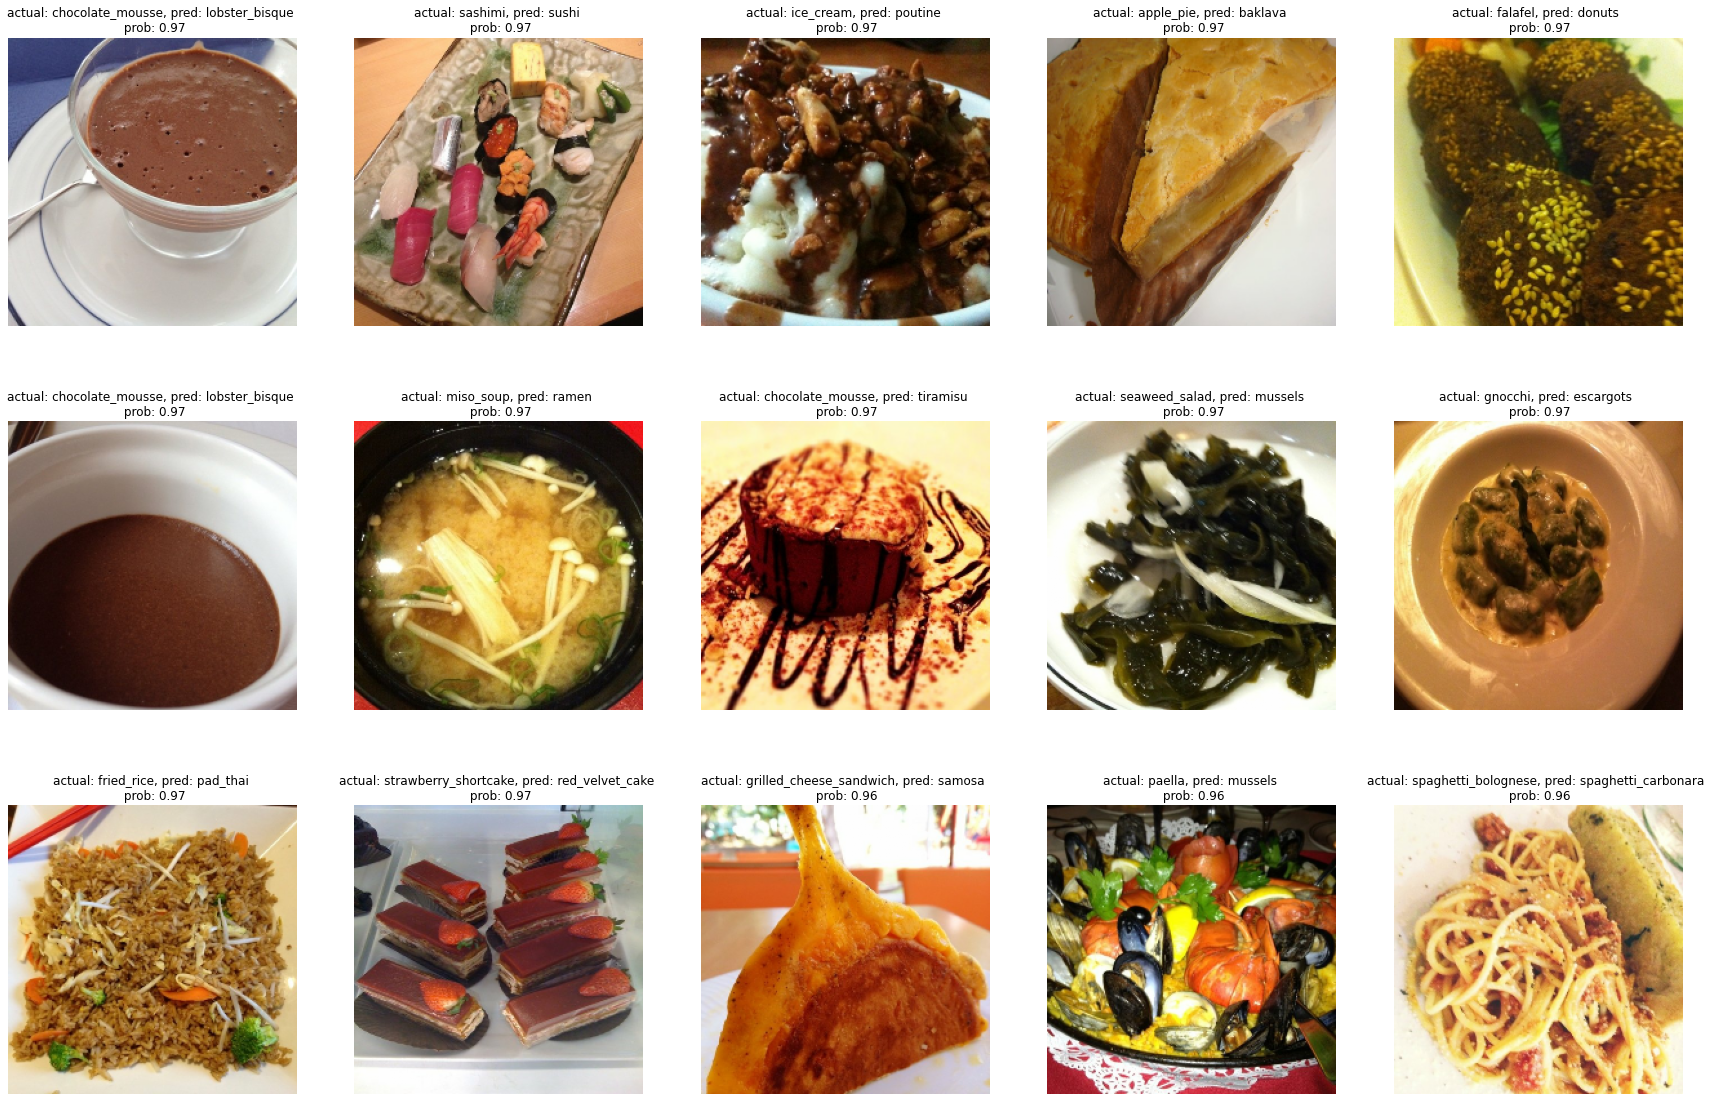

In [130]:
images_to_view = 15
start_index = 32 # change the start index to view more
plt.figure(figsize=(30, 20))
for i, row in enumerate(wrong_pred_df[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 5, i+1)
  img = load_and_prep_image(row[1], scale=True) # 'row[1]' gives you the img path
  _, _, _, _, pred_conf, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \n prob: {pred_conf:.2f}")
  plt.axis(False)

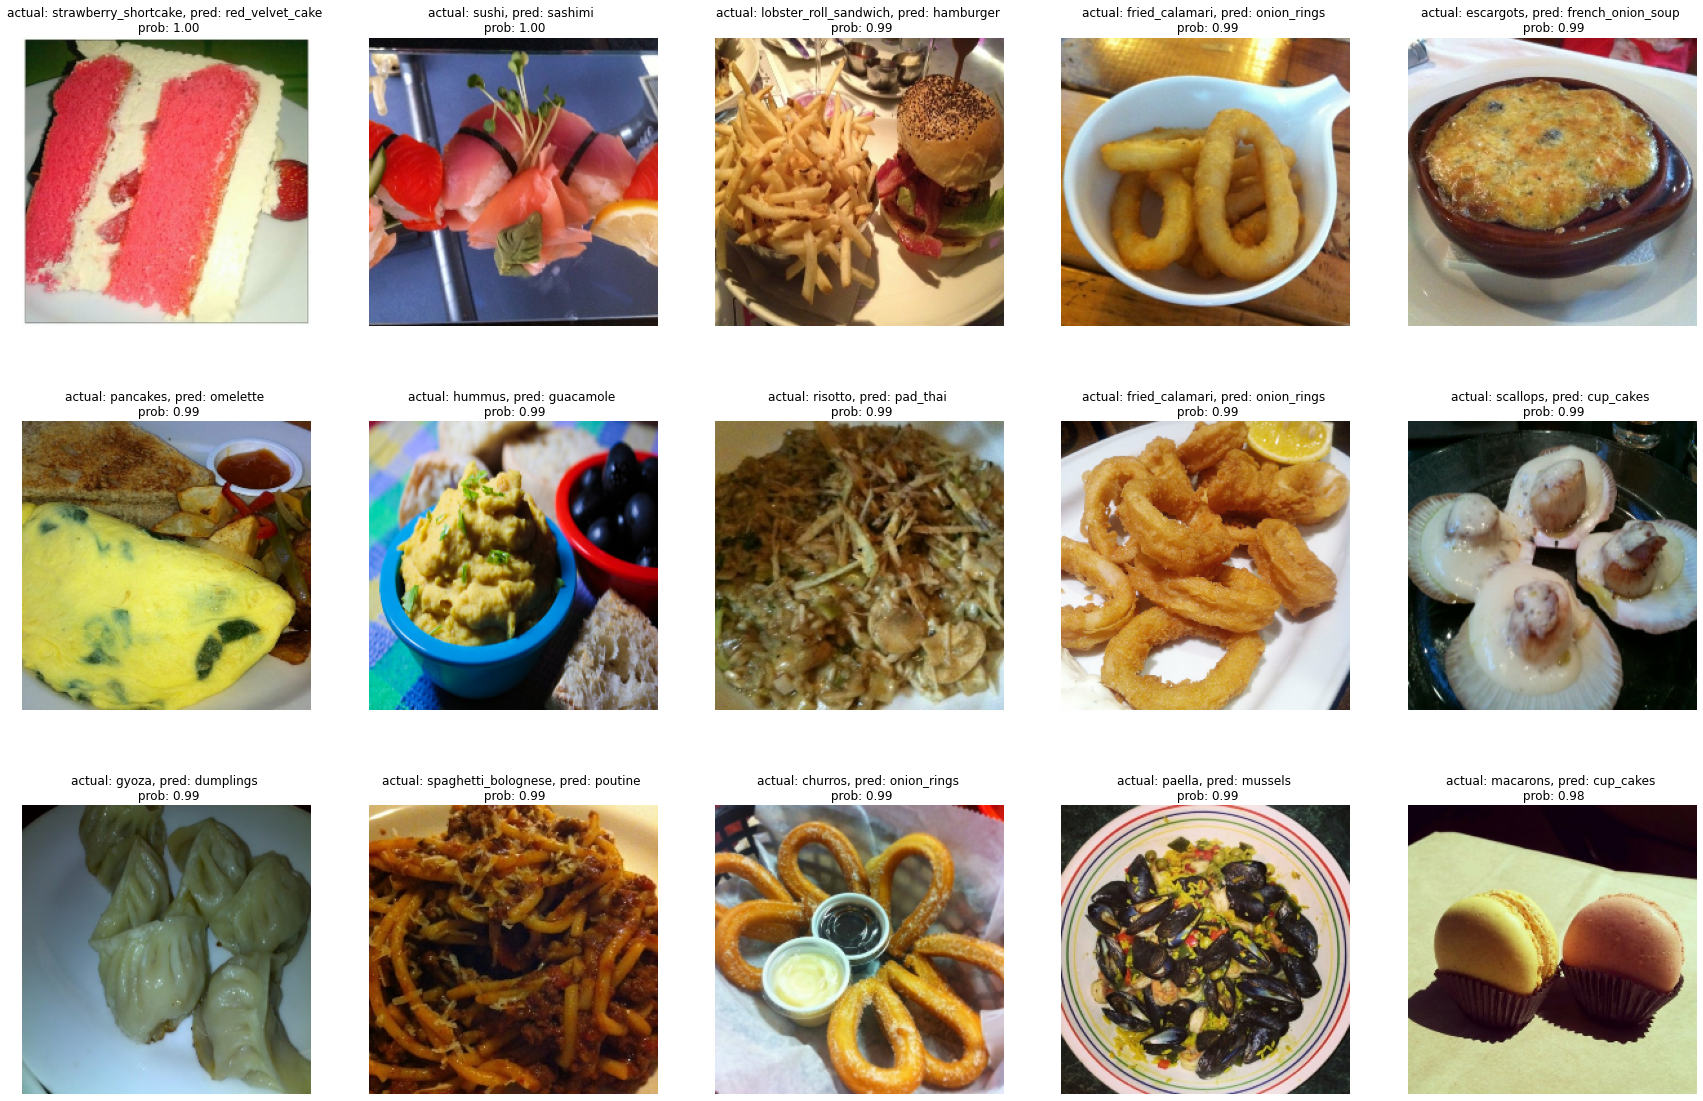

In [128]:
images_to_view = 15
start_index = 0 # change the start index to view more
plt.figure(figsize=(30, 20))
for i, row in enumerate(wrong_pred_df[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 5, i+1)
  img = load_and_prep_image(row[1], scale=False) # 'row[1]' gives you the img path
  _, _, _, _, pred_conf, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true}, pred: {y_pred} \n prob: {pred_conf:.2f}")
  plt.axis(False)

## Evaluating the model on Custom Images

In [131]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-08-03 13:47:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-08-03 13:47:42 (98.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [132]:
unzip_data('custom_food_images.zip')

In [133]:
walk_through_dir('custom_food_images')

There are 0 directories and 6 images in 'custom_food_images'.


In [134]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg']

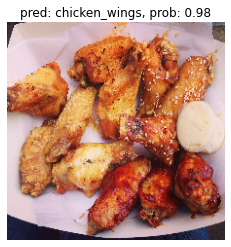

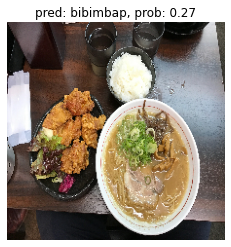

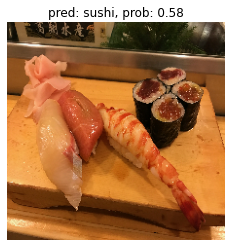

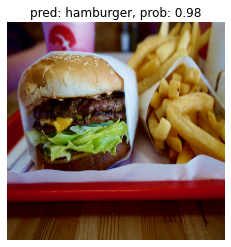

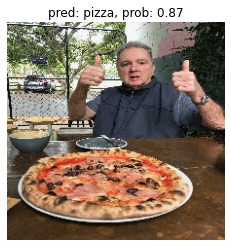

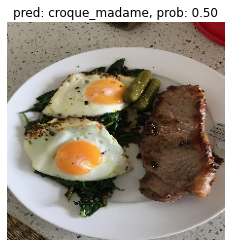

In [135]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model_final.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)